In [1]:
import numpy as np
import itk
from itk import RTK as rtk
from FanbeamDccWithBackprojectionPlane import LinesMomentCorner
from GeneralFunctions import RecupParam, ExtractSlice
from FanbeamDccOnPhysicalDetector import *
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


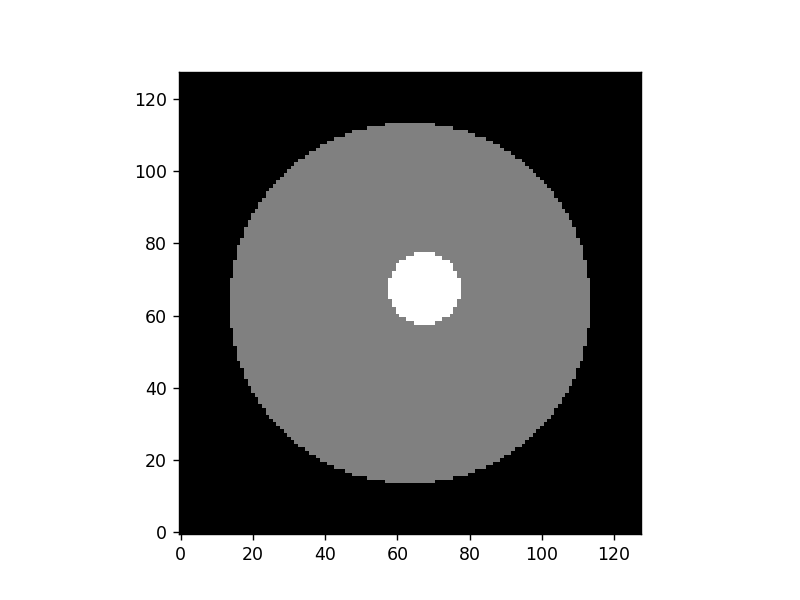

In [2]:
# Phantom computation
# We consider a simple cylinder
# Create a temporary text file for the phantom information
f = open("cylinder.txt","w")
f.write("Phantom\n")
f.write("{ [ Cylinder_y: x=0 y=0 z=0 l=200 r=50 ] rho=1. }\n")
f.write("{ [ Cylinder_y: x=4 y=0 z=4 l=200 r=10 ] rho=2. }\n")
f.close()

# Define the image type, we will use 3D float images in these hands-on sessions
ImageType = itk.Image[itk.F,3]

# Create an image filled with 0 in which we will draw the phantom
srcdraw = rtk.ConstantImageSource[ImageType].New()
srcdraw.SetSize([128,128,128])
srcdraw.SetSpacing([1]*3)
srcdraw.SetOrigin([-63.5,-63.5,-63.5])

cyldraw = rtk.DrawGeometricPhantomImageFilter[ImageType, ImageType].New()
cyldraw.SetInput(srcdraw.GetOutput())
cyldraw.SetConfigFile("cylinder.txt")
cyldraw.IsForbildConfigFileOn()
cyldraw.InPlaceOff()
cyldraw.Update()
reference = itk.GetArrayFromImage(cyldraw.GetOutput())

plt.figure()
plt.imshow(reference[:,64,:],cmap='gray',origin='lower')
plt.show()

In [3]:
# Geometry of the acquisition
# choose helical or circular trajectory
d = 0.85*16*1.2  # helical
# d = 0  # circular

# Parameters (mm)
sid = 595.0
sdd = 1085.6
sx = 0.
dx = 0.
oa = 0.
ia = 0.

# chose two angles and defined de correspondings axial positions of source and detector center
ga = np.array([0.,60.])*np.pi/180  # angles in degrees in the array
sy = d*ga/(2*np.pi)
dy = np.copy(sy)
# print(ga,sy)

geometry = rtk.ThreeDCircularProjectionGeometry.New()
geometry.SetRadiusCylindricalDetector(sdd)
for i in range(ga.shape[0]):
    geometry.AddProjectionInRadians(sid,sdd,ga[i],0.,dy[i],0.,0.,0.,sy[i])

<IPython.core.display.Javascript object>


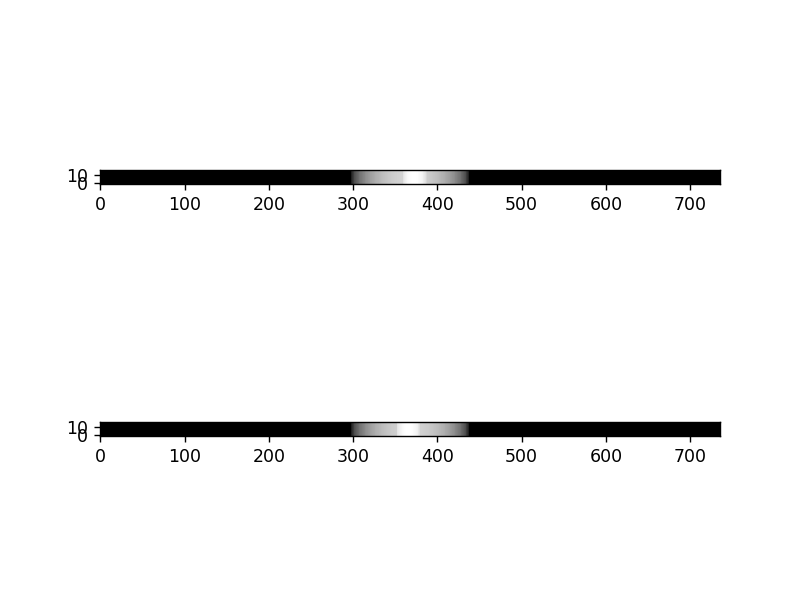

In [4]:
# Do the projections
projsize = [736,16,2]
projspacing =[1.3,1.2,1.] 
projorigin = -0.5*(np.array(projsize)-1)*np.array(projspacing)

srcproj=rtk.ConstantImageSource[ImageType].New()
srcproj.SetSize(projsize)
srcproj.SetSpacing(projspacing)
srcproj.SetOrigin(projorigin)

cylproj = rtk.ProjectGeometricPhantomImageFilter[ImageType, ImageType].New()
cylproj.SetInput(srcproj.GetOutput())
cylproj.SetConfigFile("cylinder.txt")
cylproj.SetGeometry(geometry)
cylproj.IsForbildConfigFileOn()
cylproj.Update()
proj = cylproj.GetOutput()
# itk.imwrite(cylproj.GetOutput(),'proj.mha')
sinogram = itk.GetArrayFromImage(cylproj.GetOutput())

plt.figure()
plt.subplot(211)
plt.imshow(sinogram[0,:,:],cmap='gray',origin='lower')
plt.subplot(212)
plt.imshow(sinogram[1,:,:],cmap='gray',origin='lower')
plt.show()

In [5]:
# # filesdir_ref ="/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/3D_patients/boussaid/donneesBrutes/inspi_bloquee/"
# filesdir_ref = "/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/MotionDetectionDccOnDetectors/thorax/paper/"
# # reading projections
# # proj = itk.imread(filesdir_ref+'proj.mhd')
# proj = itk.imread(filesdir_ref+'736x128_projections_170.mha')
# # Reading the geometry of the scanner
# xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
# xmlreader.SetFilename(filesdir_ref+'736x128_geometry_170.xml')
# # xmlreader.SetFilename(filesdir_ref+'geometry.xml')
# xmlreader.GenerateOutputInformation()
# geometry = xmlreader.GetOutputObject()
# print('nproj = %d'%(len(geometry.GetGantryAngles())))

nproj = 360


595.0 1085.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1085.6
a0 = 0.000000 °
595.0 1085.6 1.0471975511965976 0.0 2.7199999999999998 0.0 0.0 0.0 2.7199999999999998 1085.6
a1 = 60.000000 °
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 0.5        0.        -0.8660254  0.       ]
 [ 0.         1.         0.         0.       ]
 [ 0.8660254  0.         0.5        0.       ]
 [ 0.         0.         0.         1.       ]]
[[ 0.5        0.        -0.8660254  0.       ]
 [ 0.         1.         0.         0.       ]
 [ 0.8660254  0.         0.5        0.       ]
 [ 0.         0.         0.         1.       ]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


<IPython.core.display.Javascript object>


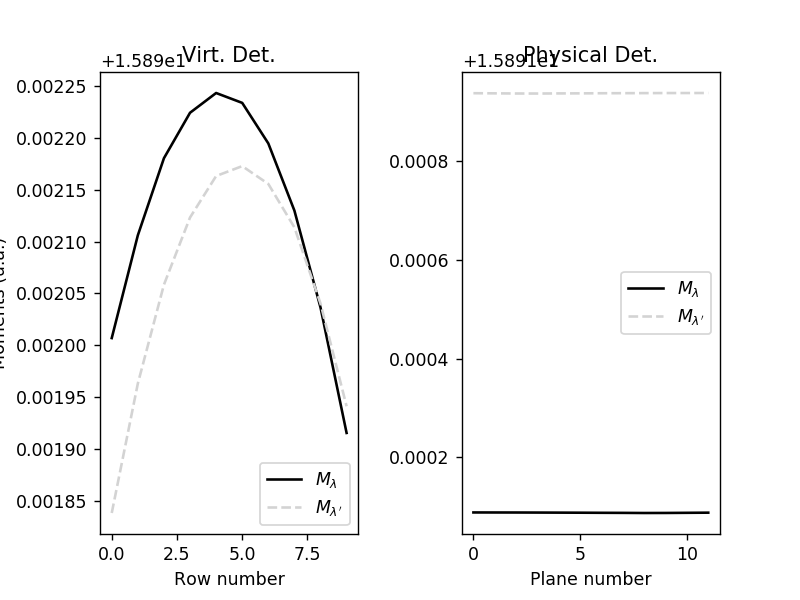

In [5]:
p0 = ExtractSlice(proj,0)
p1 = ExtractSlice(proj,1)
g0 = rtk.ThreeDCircularProjectionGeometry.New()
sid,sdd,ga0,dx0,dy0,oa,ia,sx0,sy0,R = RecupParam(geometry,0)
print(sid,sdd,ga0,dx0,dy0,oa,ia,sx0,sy0,R)
print('a0 = %f °' %(ga0*180/np.pi))
g0.SetRadiusCylindricalDetector(R)
g0.AddProjectionInRadians(sid,np.round(sdd,1),ga0,dx0,dy0,oa,ia,sx0,sy0)
g1 = rtk.ThreeDCircularProjectionGeometry.New()
sid,sdd,ga1,dx,dy,oa,ia,sx,sy,R = RecupParam(geometry,1)
print(sid,sdd,ga1,dx,dy,oa,ia,sx,sy,R)
print('a1 = %f °' %(ga1*180/np.pi))
g1.SetRadiusCylindricalDetector(R)
g1.AddProjectionInRadians(sid,np.round(sdd,1),ga1,dx,dy,oa,ia,sx,sy)

# Compute moments with backprojection plane
m0, vo0, voc0, vd0, vk0, arf0, invMag0, spwy0 = LinesMomentCorner(g0,g1,p0)
m1, vo1, voc1, vd1, vk1, arf1, invMag1, spwy1 = LinesMomentCorner(g1,g0,p1)

vo0bis = np.dot(vd0.T,vo0)
voc0bis = np.dot(vd0.T,voc0)
vo1bis = np.dot(vd1.T,vo1)
voc1bis = np.dot(vd1.T,voc1)

# # Compute moments on the physical detectors
if R == 0:
    m0bis, m1bis = ComputeMomentsOnFlatDetectors(g0,g1,p0,p1)
else:
    m0bis, m1bis = ComputeMomentsOnCylindricalDetectors(g0,g1,p0,p1)


plt.figure()
plt.subplot(121)
plt.plot(m0,'k',label = r"$M_\lambda$")
plt.plot(m1,'--',color='lightgray',label = r"$M_{\lambda'}$")
ax = plt.gca()
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.subplots_adjust(wspace = 0.4)
plt.legend()
plt.ylabel('Moments (u.a.)')
plt.xlabel('Row number')
plt.title("Virt. Det.")
# plt.title("Virt. Det., E = %.3f" %(np.sum(np.abs((m0-m1)/np.mean((m0,m1),axis=0)))))
plt.subplot(122)
plt.plot(m0bis,'k',label = r"$M_\lambda$")
plt.plot(m1bis,'--',color = 'lightgray',label = r"$M_{\lambda'}$")
plt.xlabel('Plane number')
ax = plt.gca()
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
# plt.subplots_adjust(wspace = 0.4)
plt.legend()
# plt.title("Physical Det., E = %.3f" %(np.sum(np.abs((m0bis-m1bis)/np.mean((m0bis,m1bis),axis=0)))))
plt.title("Physical Det.")
plt.show()

# print("Central plane values")
# print(m0[m0.shape[0]//2], m1[m1.shape[0]//2], m0bis[m0bis.shape[0]//2], m1bis[m1bis.shape[0]//2])

<IPython.core.display.Javascript object>


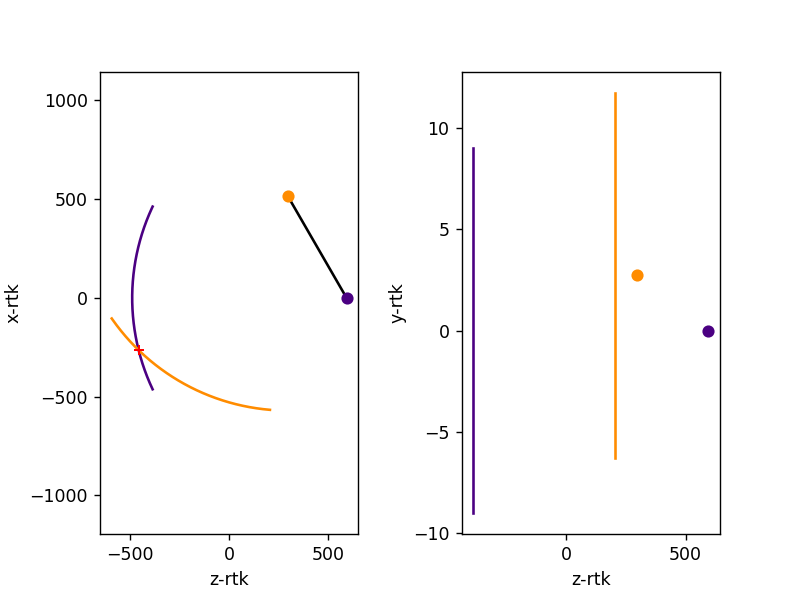

In [6]:
# Geometrical illustration of the pair, M points and new frame
sourcePos0, sourcePos1 = ExtractSourcePosition(g0, g1)
D = g0.GetSourceToDetectorDistances()[0]
R = g0.GetSourceToIsocenterDistances()[0]
dx0, dx1 = g0.GetProjectionOffsetsX()[0], g1.GetProjectionOffsetsX()[0]
sx0, sx1 = g0.GetSourceOffsetsX()[0], g1.GetSourceOffsetsX()[0]
sy0, sy1 = g0.GetSourceOffsetsY()[0], g1.GetSourceOffsetsY()[0]
dy0, dy1 = g0.GetProjectionOffsetsY()[0], g1.GetProjectionOffsetsY()[0]
Det0, Det1, gamma_RTK = ComputeDetectorsPosition(g0, g1, p0, p1)
PMs = ComputeNewFrameAndMPoints(p0.GetLargestPossibleRegion().GetSize()[0], p0.GetSpacing()[1], Det0, Det1, g0, g1)


plt.figure()
plt.subplot(1,2,1)
plt.plot([sourcePos0[2],sourcePos1[2]],[sourcePos0[0],sourcePos1[0]],'k')
plt.plot(sourcePos0[2],sourcePos0[0],'.',markersize = 12 ,color = 'indigo')
plt.plot(sourcePos1[2],sourcePos1[0],'.',markersize = 12 ,color = 'darkorange')
plt.plot(Det0[:,0,2],Det0[:,0,0],color = 'indigo' )
plt.plot(Det1[:,0,2],Det1[:,0,0],color = 'darkorange' )
plt.plot([PMs[2][:]],[PMs[0][:]],'r+')
# plt.plot([vo0[2],voc0[2]],[vo0[0],voc0[0]],'r')
# plt.plot([vo0bis[2],voc0bis[2]],[vo0bis[0],voc0bis[0]],'k--')
plt.axis('equal')
plt.xlabel('z-rtk')
plt.ylabel('x-rtk')
plt.subplots_adjust(wspace = 0.4)
plt.subplot(1,2,2)
plt.plot(sourcePos0[2],sourcePos0[1],'.',markersize = 12 ,color = 'indigo')
plt.plot(sourcePos1[2],sourcePos1[1],'.',markersize = 12 ,color = 'darkorange')
plt.plot(Det0[0,:,2],Det0[0,:,1],color = 'indigo' )
plt.plot(Det1[0,:,2],Det1[0,:,1],color = 'darkorange' )
# plt.plot(PMs[2][:],PMs[1][:],'r--')
# plt.plot([vo0[2],voc0[2]],[vo0[1],voc0[1]],'r')
# plt.plot([vo0bis[2],voc0bis[2]],[vo0bis[1],voc0bis[1]],'k--')
# plt.plot([PMs[2][PMs.shape[1]//2]],[PMs[1][PMs.shape[1]//2]],'r+')
# plt.plot([PMs[2][0]],[PMs[1][0]],'r+')
# plt.plot([sourcePos0[2],sourcePos1[2]],[sourcePos0[1],sourcePos1[1]],'k')
# plt.plot([sourcePos0[2],PMs[2][row]],[sourcePos0[1],PMs[1][row]],'k')
# plt.plot([sourcePos1[2],PMs[2][row]],[sourcePos1[1],PMs[1][row]],'k')
# plt.axis('equal')
plt.xlabel('z-rtk')
plt.ylabel('y-rtk')
plt.show()



<IPython.core.display.Javascript object>


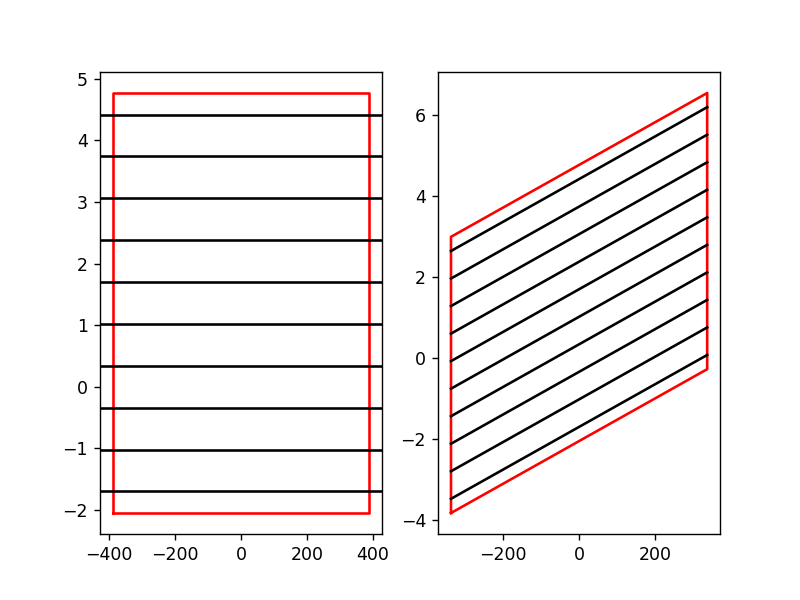

In [7]:
c0v = vo0bis
c1v = np.array([vo0bis[0],voc0bis[1],vo0bis[2]])
c2v = voc0bis
c3v = np.array([voc0bis[0],vo0bis[1],voc0bis[2]])

c0r = np.dot(vd0,c0v)
c1r = np.dot(vd0,c1v)
c2r = np.dot(vd0,c2v)
c3r = np.dot(vd0,c3v)

lines_virt_det0 = np.zeros((2,len(vk0),3))
lines_real_det0 = np.zeros((2,len(vk0),3))
lines_virt_det0[0,:,0] += np.ones(len(vk0))*vo0bis[0]
lines_virt_det0[1,:,0] += np.ones(len(vk0))*voc0bis[0]
lines_virt_det0[0,:,1] += vk0
lines_virt_det0[1,:,1] += vk0

for i in range(lines_real_det0.shape[0]):
    for j in range(len(vk0)):
        lines_real_det0[i,j,:] += np.dot(vd0,lines_virt_det0[i,j,:]+np.array([0.,spwy0,0.]))
        
        
plt.figure()
plt.subplot(121)
plt.plot([vo0bis[0],vo0bis[0],voc0bis[0],voc0bis[0],vo0bis[0]],[vo0bis[1],voc0bis[1],voc0bis[1],vo0bis[1],vo0bis[1]],'r')
for i in range(len(vk0)):
    plt.axhline(y=vk0[i]+spwy0,color='k')
plt.subplot(122)
plt.plot([c0r[0],c1r[0],c2r[0],c3r[0],c0r[0]],[c0r[1],c1r[1],c2r[1],c3r[1],c0r[1]],'r')
for i in range(len(vk0)):
    plt.plot(lines_real_det0[:,i,0],lines_real_det0[:,i,1],color='k')
plt.show()

<IPython.core.display.Javascript object>


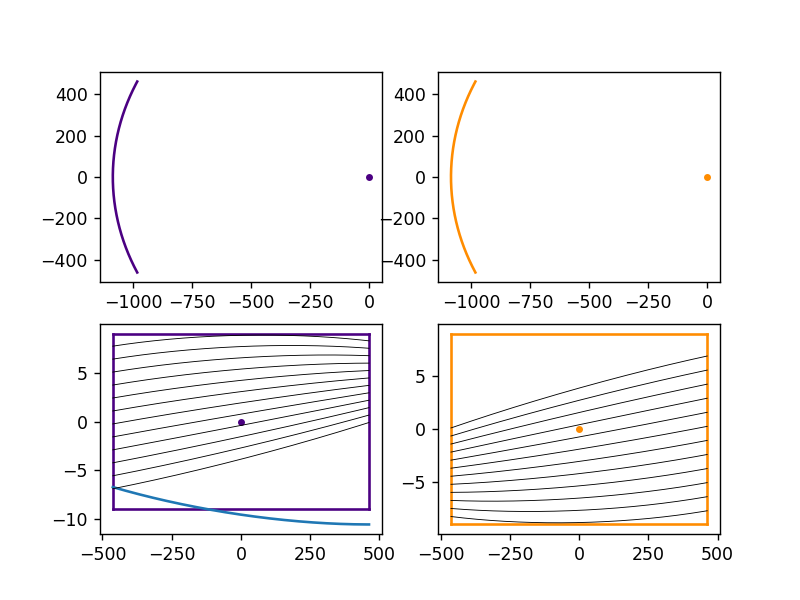

<IPython.core.display.Javascript object>


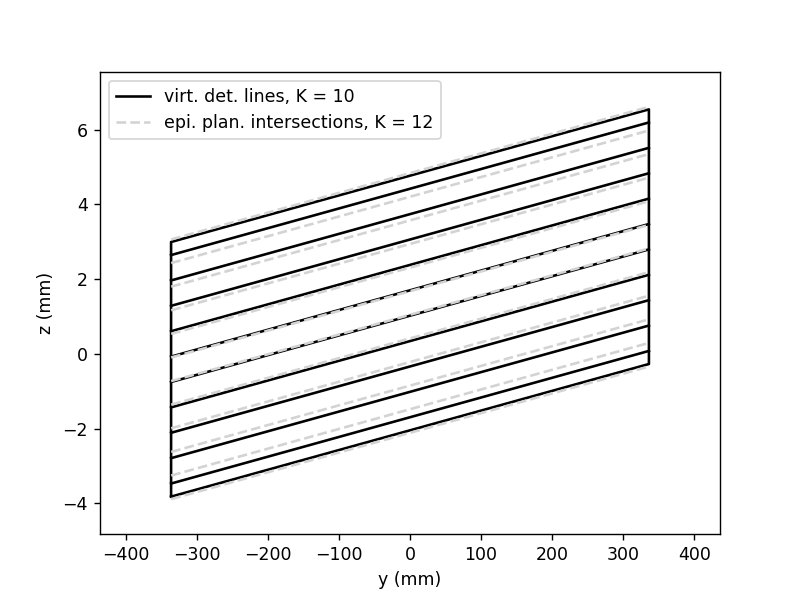

In [14]:
def ComputePlanesIntersection(nb, ne, de):
    uy = 1/(-(nb[1]+nb[2]*(ne[0]*nb[1]-ne[1]*nb[0])/(nb[0]*ne[2]-ne[0]*nb[2]))/nb[0])
    uz = 1/(-(nb[2]+nb[1]*(ne[0]*nb[2]-ne[2]*nb[0])/(nb[0]*ne[1]-ne[0]*nb[1]))/nb[0])
    ux = 1.
    ay = uy * (-nb[2]*de)/(nb[0]*ne[2]-ne[0]*nb[2])
    az = uz * (-nb[1]*de)/(nb[0]*ne[1]-ne[0]*nb[1])
    ax = 0.
    return np.array([ux,uy,uz]), np.array([ax, ay, az])

# Compute intersection between the two detectors and all possible M points
directionProj = itk.GetArrayFromMatrix(p0.GetDirection())

v_det =  p0.GetOrigin()[1] +  dy0-sy0 + (np.arange(Det0.shape[1])*p0.GetSpacing()[1])*directionProj[1, 1] 
M_ACC, n0, b0, n1, b1 = ComputeAllInOneFunction(ga0, ga1, sourcePos0, sourcePos1, PMs, gamma_RTK, v_det, D)

volDir0 = np.vstack((np.array([np.cos(ga0),0,-np.sin(ga0)]),np.array([0,1,0]),np.array([np.sin(ga0),0,np.cos(ga0)])))
volDir1 = np.vstack((np.array([np.cos(ga1),0,-np.sin(ga1)]),np.array([0,1,0]),np.array([np.sin(ga1),0,np.cos(ga1)])))

vecdir = np.zeros(M_ACC.shape)
point  = np.zeros(M_ACC.shape)

for j in range(M_ACC.shape[0]):
    Mpoint = np.array([M_ACC[j][0],M_ACC[j][1],M_ACC[j][2]])
    plane = ComputePlaneEquation(sourcePos0, sourcePos1, Mpoint)
    #intersection bp and epipolar
    vecdir[j,:], point[j,:] = ComputePlanesIntersection(vd0.T[2,:], plane[0], plane[1])

Det0bis = np.zeros(Det0.shape)
Det1bis = np.zeros(Det0.shape)

for i in range(Det0bis.shape[0]):
    for j in range(Det0bis.shape[1]):
        Det0bis[i,j,:] +=np.dot(volDir0,Det0[i,j,:]-sourcePos0)
        Det1bis[i,j,:] +=np.dot(volDir1,Det1[i,j,:]-sourcePos1)

plt.figure()
plt.subplot(221)
plt.plot([0],[0],'.', color='indigo')
plt.plot(Det0bis[:,0,2],Det0bis[:,0,0],color = 'indigo' )
plt.subplot(222)
plt.plot([0],[0],'.', color='darkorange')
plt.plot(Det1bis[:,0,2],Det1bis[:,0,0],color = 'darkorange' )
plt.subplot(223)
plt.plot([0],[0],'.', color='indigo')
plt.plot(Det0bis[:,0,0],Det0bis[:,0,1],color = 'indigo')
plt.plot(Det0bis[:,-1,0],Det0bis[:,-1,1],color = 'indigo')
plt.plot(Det0bis[0,:,0],Det0bis[0,:,1],color = 'indigo')
plt.plot(Det0bis[-1,:,0],Det0bis[-1,:,1],color = 'indigo')
psi = - np.pi/2 + gamma_RTK[0]
#kappa curve
plt.plot(Det0bis[:,0,0], D*d*(psi*np.cos(gamma_RTK)+psi*np.sin(gamma_RTK)/np.tan(psi))/(2*np.pi*R))
for j in range(n0.shape[0]):
    plt.plot(Det0bis[:,0,0],D*(-np.sin(gamma_RTK)*n0[j,0]+np.cos(gamma_RTK)*n0[j,2])/n0[j,1],color='k',linewidth=0.5)
# plt.plot(Det0bis[:,0,0],D*(-np.sin(gamma_RTK)*n0[-1,0]+np.cos(gamma_RTK)*n0[-1,2])/n0[-1,1])
# plt.plot(Det0bis[:,0,0],D*d*(np.pi/2-gamma_RTK)/(2*np.pi*R*np.cos(gamma_RTK)),color = 'red')
# plt.plot(Det0bis[:,0,0],-D*d*(np.pi/2+gamma_RTK)/(2*np.pi*R*np.cos(gamma_RTK)),color = 'red')
plt.subplot(224)
plt.plot([0],[0],'.', color='darkorange')
plt.plot(Det1bis[:,0,0],Det1bis[:,0,1],color = 'darkorange')
plt.plot(Det1bis[:,-1,0],Det1bis[:,-1,1],color = 'darkorange')
plt.plot(Det1bis[0,:,0],Det1bis[0,:,1],color = 'darkorange')
plt.plot(Det1bis[-1,:,0],Det1bis[-1,:,1],color = 'darkorange')
for j in range(n0.shape[0]):
    plt.plot(Det1bis[:,0,0],D*(-np.sin(gamma_RTK)*n1[j,0]+np.cos(gamma_RTK)*n1[j,2])/n1[j,1],color='k',linewidth=0.5)
# plt.plot(Det1bis[:,0,0],D*d*(np.pi/2-gamma_RTK)/(2*np.pi*R*np.cos(gamma_RTK)),color = 'red')
# plt.plot(Det1bis[:,0,0],-D*d*(np.pi/2+gamma_RTK)/(2*np.pi*R*np.cos(gamma_RTK)),color = 'red')
plt.show()

plt.figure()
plt.plot([c0r[0],c1r[0],c2r[0],c3r[0],c0r[0]],[c0r[1],c1r[1],c2r[1],c3r[1],c0r[1]],'k',linewidth=1.5)
plt.plot(lines_real_det0[:,0,0],lines_real_det0[:,0,1],color='k',label='virt. det. lines, K = %d' %(len(vk0)))
for i in range(1,len(vk0)):
    plt.plot(lines_real_det0[:,i,0],lines_real_det0[:,i,1],color='k')
dint=np.array([point[0,:]+t*vecdir[0,:] for t in np.arange(np.round(c0r[0]),np.round(c3r[0]))])
plt.plot(dint[:,0],dint[:,1],'--',color = 'lightgray',label='epi. plan. intersections, K = %d' %(len(M_ACC)))
for j in range(1,M_ACC.shape[0]):
    dint=np.array([point[j,:]+t*vecdir[j,:] for t in np.arange(np.round(c0r[0]),np.round(c3r[0]))])
    plt.plot(dint[:,0],dint[:,1],'--',color = 'lightgray')
plt.xlim((min([c0r[0],c1r[0],c2r[0],c3r[0],c0r[0]])-100,max([c0r[0],c1r[0],c2r[0],c3r[0],c0r[0]])+100))
plt.ylim((min([c0r[1],c1r[1],c2r[1],c3r[1],c0r[1]])-1,max([c0r[1],c1r[1],c2r[1],c3r[1],c0r[1]])+1))
plt.legend()
plt.xlabel('y (mm)')
plt.ylabel('z (mm)')
plt.show()



In [9]:
len(vk0), len(M_ACC)

(10, 12)

In [10]:
v_det, Det0bis[0,:,1]

(array([-9. , -7.8, -6.6, -5.4, -4.2, -3. , -1.8, -0.6,  0.6,  1.8,  3. ,
         4.2,  5.4,  6.6,  7.8,  9. ]),
 array([-9. , -7.8, -6.6, -5.4, -4.2, -3. , -1.8, -0.6,  0.6,  1.8,  3. ,
         4.2,  5.4,  6.6,  7.8,  9. ]))